### Quick and dirty stock diversity analysis 1 - Find opposite groups the unsupervised way

A step-by-step guide to cluster stocks and identify interesting stock trends! So simple, a caveman can do it! All transformation done to the data are explained, if not, shout at me.

**Questions**
1. How to cluster stock trends?
2. How to find very different stock clusters and visualize their differences?

**We will transform, optimize, cluster, plot!**

We will use the **history_60d.csv** files in the https://www.kaggle.com/qks1lver/amex-nyse-nasdaq-stock-histories dataset, which has about 41 trading days of around 7800 stocks.

2019.4.14 edit: I really didn't like the way I previously calculate the 2 most apart clusters (too lazy and too tired), so I updated it to a slightly more complex but more correct one.

In [12]:
import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import decomposition
from sklearn.preprocessing import scale, minmax_scale
from sklearn import cluster
from scipy.optimize import minimize
from scipy.spatial.distance import euclidean

['fh_20190420', 'history_60d.csv']


In [2]:
# Load data and preview a bit
p_history = '../input/history_60d.csv'
df = pd.read_csv(p_history)
display(df.head())

,date,symbol,volume,open,close,high,low,adjclose
0,2019-04-18,A,2874100,75.730003,76.169998,76.540001,75.309998,76.169998
1,2019-04-17,A,4472000,78.150002,75.430000,78.320000,74.459999,75.430000
2,2019-04-16,A,3441500,80.820000,77.550003,80.959999,77.190002,77.550003
3,2019-04-15,A,1627300,81.000000,80.400002,81.129997,79.910004,80.400002
4,2019-04-12,A,1249300,81.430000,80.980003,82.059998,80.900002,80.980003


### Question 1: How to cluster stock trends?

Let's first define trend as **relative day-to-day movement.** This means we want data on changes made during each trading day and we want to focus on the ratio of change (hint: relative data usually means taking the ratio). So, if we ask: **How has the stock changed over the course of a trading day?** One of the most straigh-forward responses would be **end-of-day price divide by start-of-day price**. Let's also **-1** that so \$110/\$ 100-1 = 0.10 and \$90/\$100-1 = -0.10. Then we try to cluster and see what we get and further analyze from there!

In [3]:
# Transform data and save that as a new data frame
# Hint: when possible (i.e. if memory permits), refrain from changing the original data frame... this can save you hours of troubleshooting when analysis gets long!

# Number of unique stock symbols in the data
ntickers0 = len(df['symbol'].unique())

# [.assign()] df get a new "diff" column with adjusted close price / open price - 1
# [.pivot_table()] Then we "pivot" data frame, so we have a new table-like data frame with unique stock symbol for each row, dates analyzing as columns, and "diff" as the values
# [.dropna()] Then to simplify this basic analysis, let's get rid of all the stocks that for some reason have fewer days of data
dfx = df.assign(diff=df['adjclose']/df['open']-1).pivot_table(index='symbol', columns='date', values='diff', aggfunc=np.max).dropna()
display(dfx.head())

# Let's see how many stocks we still have left
ntickers1 = len(dfx)
print('Number of symbols: %d (%.2f)' % (ntickers1, ntickers1/ntickers0))

# Let's scale the data row-wise (i.e. independently for each stock) and save to another data frame so we can use dfx to plot later
# Important: This is a very critical step here for better clustering.
# Primarily because stock prices are so diverse (from a dollar to thousands) and the movement pattern could be the identical between 2 stocks,
# but because prices are different, the volumes become very different thus the ratios of change are different as a result.
# i.e. Stock-A: 0.5, -0.2, 0.4 and Stock-B: 0.25, -0.1, 0.2
# It would be challenging to mine out trend groups without some sort of scaling or normalization.
# Try removing the scaled() transformation part and run the rest and see what would happen. Doesn't cluster very well, does it?
dfscaled = pd.DataFrame(scale(dfx, axis=1), index=dfx.index, columns=dfx.columns)
display(dfscaled.head())

# After scaling, the mean of each row would be very very close to zero. You can check this with np.mean(dfscaled.values, axis=1)
# The previous example of Stock-A: 0.5, -0.2, 0.4 and Stock-B: 0.25, -0.1, 0.2
# would become Stock-A: 0.86, -1.40,  0.54 and Stock-B: 0.86, -1.40,  0.54
# Now, arguably this may not be what you want, but for this analysis on trends, this is an effective transformation

date,2019-02-20,2019-02-21,2019-02-22,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-15,2019-04-16,2019-04-17,2019-04-18
symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,0.011218,0.000786,0.001279,0.003525,-0.010356,0.012881,0.001237,0.013428,-0.018816,-0.005532,-0.015418,-0.001533,-0.004593,0.010963,0.002349,-0.003160,0.004815,0.000922,-0.003640,-0.002900,-0.006460,0.015924,-0.033250,0.003385,0.001187,-0.020636,0.001856,0.000699,0.007411,-0.006976,0.004906,-0.012341,0.003449,0.001471,-0.001717,0.002824,-0.009770,-0.005526,-0.007407,-0.040460,-0.034805,0.005810
AA,0.029940,0.013014,0.009706,0.010174,0.004886,-0.002897,-0.049001,-0.000674,-0.025075,0.004472,-0.027873,-0.028409,-0.004085,0.028401,0.025604,0.012579,-0.031261,-0.001076,0.022857,-0.014123,0.010175,0.030483,-0.033677,-0.003556,-0.021322,0.000358,-0.002139,-0.004243,0.027197,-0.020254,0.008436,0.024126,0.005102,0.003723,-0.009530,-0.002054,-0.012478,-0.021107,-0.022551,-0.002878,-0.009292,-0.025585
AAAU,-0.002981,-0.008246,0.000754,-0.003757,0.001508,-0.003776,-0.005307,-0.012261,0.001558,0.002336,0.001558,0.001559,0.001541,-0.002315,0.003084,0.001530,0.001547,-0.000768,-0.001534,-0.002292,0.003058,-0.006079,0.001527,0.002276,-0.001519,-0.005323,-0.003091,-0.005393,-0.007716,0.001553,0.001554,0.007020,0.000775,-0.003077,0.000000,0.002301,-0.004626,-0.001549,0.002338,0.000785,-0.002353,0.000786
AABA,0.001732,0.003737,0.019764,0.011063,0.018798,0.013014,0.002958,-0.000533,0.004095,-0.011058,-0.011760,-0.021440,0.015426,0.011287,-0.005541,-0.001627,0.002183,-0.002438,-0.003377,0.002304,0.001222,0.006141,-0.014372,0.015213,-0.007659,-0.002757,0.002073,0.012845,-0.017612,0.004893,-0.001235,0.017222,0.007350,0.010998,0.018040,-0.001457,-0.004771,0.014286,-0.029112,0.004006,0.005416,-0.001970
AAC,0.050505,-0.057692,0.013605,0.036913,-0.022654,-0.069307,-0.092527,0.103846,-0.114983,0.015686,-0.085271,-0.008511,0.004348,0.098712,0.070039,-0.017921,-0.032967,-0.056818,-0.008065,-0.020325,-0.037500,0.004329,-0.073593,-0.051887,-0.121359,0.000000,-0.038251,0.033708,0.116402,-0.051887,0.014706,-0.033981,0.019900,0.009804,0.019417,0.023697,-0.082569,0.029557,0.033817,-0.121212,-0.043956,-0.103448


Number of symbols: 7817 (0.98)


date,2019-02-20,2019-02-21,2019-02-22,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-15,2019-04-16,2019-04-17,2019-04-18
symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,1.182601,0.324957,0.365482,0.550109,-0.591117,1.319369,0.361972,1.364324,-1.286703,-0.194556,-1.007348,0.134255,-0.117348,1.161680,0.453408,0.000492,0.656220,0.336075,-0.038974,0.021878,-0.270861,1.569553,-2.473410,0.538643,0.357921,-1.436339,0.412934,0.317729,0.869621,-0.313244,0.663627,-0.754360,0.543843,0.381255,0.119171,0.492471,-0.542998,-0.194052,-0.348721,-3.066260,-2.601287,0.737990
AA,1.689254,0.807137,0.634734,0.659148,0.383565,-0.022027,-2.424721,0.093815,-1.177854,0.361991,-1.323677,-1.351596,-0.083939,1.609022,1.463282,0.784462,-1.500219,0.072835,1.320125,-0.607099,0.659225,1.717571,-1.626131,-0.056397,-0.982251,0.147613,0.017459,-0.092205,1.546276,-0.926596,0.568565,1.386247,0.394824,0.322932,-0.367733,0.021886,-0.521372,-0.971063,-1.046308,-0.021037,-0.355335,-1.204411
AAAU,-0.529415,-1.954197,0.481039,-0.739390,0.685269,-0.744765,-1.158937,-3.040542,0.698619,0.909370,0.698619,0.698968,0.694093,-0.349243,1.111672,0.691222,0.695685,0.069299,-0.137881,-0.343022,1.104654,-1.367837,0.690254,0.893061,-0.133804,-1.163305,-0.559334,-1.182171,-1.810822,0.697310,0.697656,2.176816,0.486908,-0.555473,0.277137,0.899673,-0.974677,-0.142061,0.909863,0.489542,-0.359560,0.489709
AABA,-0.031800,0.151651,1.618473,0.822117,1.530074,1.000672,0.080400,-0.239137,0.184466,-1.202391,-1.266605,-2.152532,1.221456,0.842660,-0.697401,-0.339223,0.009423,-0.413485,-0.499390,0.020548,-0.078514,0.371689,-1.505623,1.201950,-0.891252,-0.442661,-0.000641,0.985256,-1.802153,0.257449,-0.303386,1.385850,0.482342,0.816206,1.460687,-0.323667,-0.627003,1.117106,-2.854677,0.176345,0.305362,-0.370641
AAC,1.122950,-0.720020,0.494424,0.891427,-0.123194,-0.917858,-1.313370,2.031532,-1.695871,0.529867,-1.189787,0.117711,0.336735,1.944088,1.455680,-0.042582,-0.298865,-0.705132,0.125310,-0.083531,-0.376078,0.336414,-0.990865,-0.621133,-1.804487,0.262676,-0.388876,0.836838,2.245403,-0.621133,0.513168,-0.316129,0.601650,0.429671,0.593422,0.666314,-1.143754,0.766127,0.838688,-1.801982,-0.486046,-1.499403


### Clustering! This is the cool part!
DBSCAN is a pretty good clustering method, and I'll let this scikit-learn article do all the talking:
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
The tricky part is using the right epsilon (**eps**), and there's really no "right" way to do it since we don't know what clusters we want to see, or else we wouldn't be doing this. So, we can either try different eps manually **or** we can decide on **an assumption** and **an objective** and automate a search for the best eps that fits our goal.

**Assumption:** Stock trends are messy, the possibilitie are endless, so there could be as many clusters as the number of stocks out there.

**Objective function:** Find an eps that maximizes the number of clusters

In [4]:
# Find the optimal eps and generate the clusters, this can take a while.

def clust_func(i, data):
    """
    This performs DBSCAN
    Each cluster is required to have at least 5 samples, this is arbitrary but it can significantly change the result.
    Play around with the min_samples to see what happens.
    n_jobs let's you specify how many CPUs to use, I don't know how many Kaggle let me use, so just set as -1 to use as many as allowed.
    """
    return cluster.DBSCAN(eps=i, min_samples=5, n_jobs=-1).fit_predict(data.values)

def clust_min_func(i, data):
    """
    This calculates the objective function with the DBSCAN result
    i.e. count the number of clusters
    Optimization here search for the minimal objective value, thus we negate the count to get it to maximize
    """
    if i <= 0:
        return np.Inf
    return -len(np.unique(clust_func(i, data)))

# This is Scipy's minimization function, we use COBYLA to solve so we don't have to bother with figuring out a gradient function
# The initial (first test) eps is set to 1, then the minimize() function will test this first and try to find a better one from there.
res = minimize(fun=clust_min_func, x0=1, args=dfscaled, method='cobyla')

# Store cluster label of each sample to "y" (thus y is an 1-by-n_samples array)
print('Optimal epsilon: ', res.x)
y = clust_func(res.x, dfscaled)
print('Clusters:')
print(np.unique(y))

Optimal epsilon:  2.9921875
Clusters:
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23]


### Question 2: How to find very different stock clusters and visualize their differences?
Cluster with **-1** are outliers, ones that this round of DBSCAN cannot identify good clusters for, and there are likely a lot of them. For this analysis, let's just focus on the ones that got clustered. Seeing is believing. Plotting with the original data or scaled data may help us see the separations, but since clustering is done with around 40 days of data, it's likely that we'll have to plot a lot of dimensions to appreciate the separations of clusters. Instead, we can perform dimensionality **reduction techniques** (i.e. principle component analysis) to determine some of the best ways to separate the samples and return the new coordinates of the separated samples. By doing this, hopefully, we can plot fewer dimensions with the new coordinates and still see clear separations. We can also use these coordinates to automatically identify clusters that are polar opposites of each others.

Let's keep things simple. Let's just use the coordinates on the first 3 components of the PCA to identify the opposite clusters. The 1st component is always the one that can explain the highest variance in the data. But because it's stock, quite random, don't expect **comp1** to explain a lot of variance (probably around 10%), so let's take a bit more and see what happens. You can change **n_comps** to a higher value to account for more components from the PCA in calculating the opposite clusters. The following code simply compute the Euclidean distance from the lowest point of each component for each sample.

Explained variance ratio of 3 components: 0.24


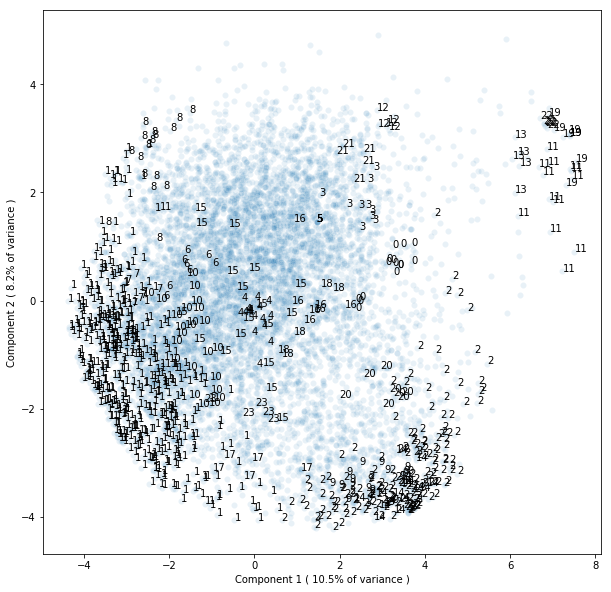

Clusters: 1 and 19


In [16]:
# Do PCA to get transformed coordinates
n_comps = 3
m = decomposition.PCA()
X = m.fit_transform(dfscaled.values)
print('Explained variance ratio of %d components: %.2f' % (n_comps, np.sum(m.explained_variance_ratio_[:n_comps])))

# Generate PCA plot of first 2 components, also store the PCA coordinates of the clustered samples to "xs"
# Not all samples are clustered, many are considered outliers (-1), let's not plot outliers
xs = [[] for _ in range(np.max(y) + 1)]
_,g = plt.subplots(figsize=(10,10))
g = sns.scatterplot(x=X[:,0], y=X[:,1], ax=g, alpha=0.1)
for idx,(i,j,k) in enumerate(zip(X[:,0], X[:,1], y)):
    if k > -1:
        g.text(x=i, y=j, s=str(k))
        xs[k].append(X[idx, :n_comps])
g.set_xlabel('Component 1 ( %.1f%% of variance )' % (m.explained_variance_ratio_[0]*100))
g.set_ylabel('Component 2 ( %.1f%% of variance )' % (m.explained_variance_ratio_[1]*100))
plt.draw()
plt.show()

# Use "xs" to determine the average position of the clusters and store to "xm"
# Scale the average positions of each cluster to their min and max along each component so they can then be weighed by
# the amount of variance explainable by each component (i.e. how userful each is) - this attempts to position the clusters more fairly,
# since we will just use 1 metric (their Euclidean distances) to determine the clusters' similarities
# Then calculate the Euclidean distances of clusters to each other
# Then identify the clusters with the largest distance from each other
xm = minmax_scale(np.array([np.mean(x, axis=0) for x in xs]), axis=0) * m.explained_variance_ratio_[:n_comps]
xdist = []   # distances
xpairs = []  # cluster pairs
for i, a in enumerate(xm[:-2]):
    for j, b in enumerate(xm):
        if j > i:
            xpairs.append((i,j))
            xdist.append(euclidean(a,b))
clusters = xpairs[np.argmax(xdist)]
print('Clusters: %d and %d' % clusters)

Each dot is a stock symbol. All the ones without a cluster ID next to them are outliers.... quite a bit, huh?

,symbol,date,value,g
0,AAXJ,2019-02-20,0.103324,g1
1,ABCB,2019-02-20,0.802550,g1
2,ABTX,2019-02-20,0.286880,g1
3,ACSI,2019-02-20,0.502747,g1
4,ACWF,2019-02-20,0.792413,g1


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


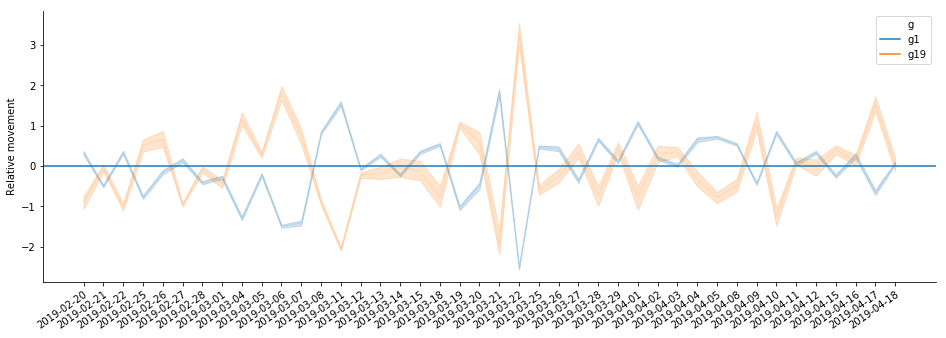

In [6]:
# Plot the scaled trends of the selected 2 clusters to see why they are separated

# Compile the data frame for plotting
# Since the cluster label of each sample is stored in "y", we can use y to get the index of the samples we want to focus on
# [pd.melt()] Transform the "dfscaled" data frame so it's just 3 columns: stock symbols (symbols), dates (date), and the scaled values (value)
# [df.reset_index()] to convert the symbol index in dfscaled to just numerical row number indices
# [df.assign()] Give each cluster a name (i.e. g1)
dfy = pd.DataFrame()
for i in clusters:
    dtmp = pd.melt(dfscaled[y==i].reset_index(), id_vars='symbol', value_vars=dfscaled.columns)
    dfy = dfy.append(dtmp.assign(g='g%d'%i), ignore_index=True)
display(dfy.head())

# Plot with Seaborn's line plot so we can see the changes in adjusted close price / open price - 1 over the 40ish days
fig,g = plt.subplots(figsize=(16,5))
g = sns.lineplot(data=dfy, x='date', y='value', hue='g', ax=g, alpha=.1)
g.set_xlabel('')
g.set_ylabel('Relative movement')
plt.setp(g.get_xticklabels(), rotation=35, ha='right', va='top', rotation_mode='anchor')
g.axhline(y=0.)
sns.despine()
plt.draw()
plt.show()
fig.tight_layout()

The 2 patterns should look **almost** like opposites of each other.

,index,date,symbol,volume,open,close,high,low,adjclose,g
0,714,2019-04-18,AAXJ,911100,73.070000,73.260002,73.360001,72.940002,73.260002,g1
1,715,2019-04-17,AAXJ,685400,73.570000,73.400002,73.650002,73.269997,73.400002,g1
2,716,2019-04-16,AAXJ,446600,73.059998,73.099998,73.190002,72.989998,73.099998,g1
3,717,2019-04-15,AAXJ,1030800,72.930000,72.599998,72.970001,72.370003,72.599998,g1
4,718,2019-04-12,AAXJ,775400,73.199997,73.199997,73.290001,73.019997,73.199997,g1


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


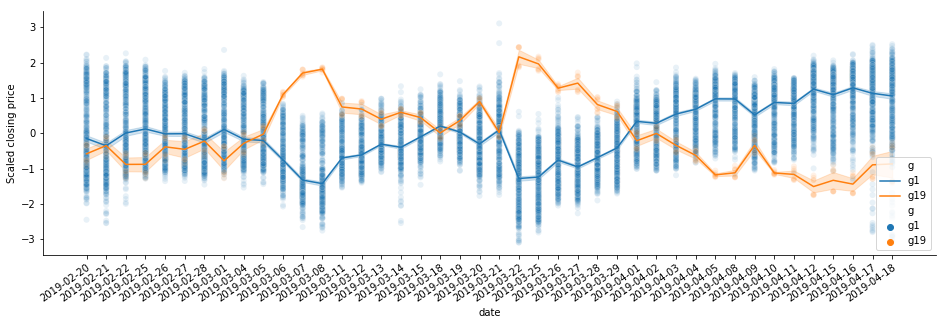

In [7]:
# Now, what does the closing prices (untransformed) look like for these selected clusters?

# Compile the data frame for plotting
# Use the first data frame (df), but only if the symbols are the ones within the clusters
dfy = pd.DataFrame()
for i in clusters:
    dtmp = df[df['symbol'].isin(dfx[y==i].index)].reset_index()
    dfy = dfy.append(dtmp.assign(g='g%d'%i), ignore_index=True)
display(dfy.head())

# But! Because prices of stocks vary so much, we will unlikely see clear patterns (i.e. stock prices of the same cluster overlaying)
# So we much scale the prices of each stock, so the stocks are comparable
yscaled = []
for s in dfy['symbol'].unique():
    yscaled.append(dfy[dfy['symbol']==s]['adjclose'].values)
yscaled = scale(yscaled, axis=1)
dfy = dfy.assign(y=np.concatenate(yscaled))

# Plotting with line plot as we did before
fig,g = plt.subplots(figsize=(16,5))
g = sns.lineplot(data=dfy, x='date', y='y', hue='g', ax=g)
g = sns.scatterplot(data=dfy, x='date', y='y', hue='g', ax=g, alpha=0.1)
g.set_ylabel('Scaled closing price')
fig.autofmt_xdate()
plt.setp(g.get_xticklabels(), rotation=35, ha='right', va='top', rotation_mode='anchor')
sns.despine()
plt.draw()
plt.show()
fig.tight_layout()

Whenever one cluster goes up, the other should go down. Each dot in a column (a day) represents a stock symbol of that cluster (color-coded).

In [8]:
# What are the stocks in these clusters?
print('Cluster 1: ', ', '.join(dfx[y==clusters[0]].index.values))
print('\nCluster 2: ', ', '.join(dfx[y==clusters[1]].index.values))

Cluster 1:  AAXJ, ABCB, ABTX, ACSI, ACWF, ACWI, ACWX, ADX, AIA, AIEQ, AIRR, AMAT, AOA, AOR, ARKF, ARKG, ARKK, ARKW, ASB, BAC, BANF, BANR, BBC, BBEU, BBH, BBJP, BBP, BFOR, BIB, BKF, BKU, BMTC, BOH, BOKF, BOTZ, BUSE, BXS, CATY, CBSH, CBU, CDC, CDL, CFA, CFG, CFO, CFR, CIBR, CIT, CMA, CNOB, COLB, COWZ, CRBN, CRM, CSM, CSML, CVBF, CVY, CWB, CWI, CXSE, CZA, DBEF, DBEU, DBJP, DDM, DDWM, DEM, DES, DEUS, DEW, DFE, DFEN, DFJ, DGRO, DGRS, DGRW, DGS, DHS, DIA, DLN, DLS, DNI, DNL, DOL, DON, DOO, DPST, DSI, DTD, DTH, DTN, DVY, DWAS, DWM, DWX, DXJ, DXJS, EDC, EDIV, EEM, EEMS, EEMV, EES, EET, EFA, EFAV, EFG, EFV, EMGF, EPP, EPS, EQAL, EQL, ESGD, ESGE, ESGU, ESGV, EUDG, EURL, EUSA, EWA, EWBC, EWD, EWG, EWJ, EWL, EWN, EWQ, EWT, EWU, EWX, EWY, EXI, EZA, EZM, EZU, FAS, FBNC, FBT, FCF, FCNCA, FDIS, FDL, FDLO, FDM, FDMO, FDN, FDRR, FDT, FDVV, FEM, FEP, FEX, FEZ, FFBC, FFTY, FIDU, FINU, FITB, FIW, FLCH, FLGE, FLJP, FMAT, FMBI, FNB, FNCL, FNDA, FNDB, FNDC, FNDE, FNDF, FNDX, FNX, FNY, FPX, FQAL, FRME, FTA, FT

### Conclusions
It is possible to cluster and identify stocks with opposite trends with fairly simple statistical methods. Here we performed **DBSCAN to find the clusters**, used **PCA to reduce data dimensions** so we can visualize the clusters, used the PCA coordinates to **find the clusters with polar opposite stock movements**, proved that we actually found clusters with opposite movements, and listed what they are!

### What's next?
Notice how we didn't get to cluster everything and a lot of good stocks are left out in the dark (outliers). Next time, we'll explore ways to get them all and optimize your portfolio so it is diverse enough to withstand any unforeseeable economical disaster... sorta! No stock gets left behind!

### Also...
Let me know if you have questions about this kernel or find a mistake or disagree with something. Thanks!

Happy mining!

Jiun